In [1]:
# load relevant packages, set some display parameters
%reset -f

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RepeatedKFold
from math import sqrt
from scipy import stats
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
import ifsg
import glob, os #I ADDED
from sklearn.svm import SVR, LinearSVR #I ADDED
from sklearn.tree import DecisionTreeRegressor #I ADDED
import pickle
import re
import random
import os
import warnings
import seaborn as sns
import gc
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

#ifsg.__version__

In [2]:
# set paths
x=os.path.splitext(os.path.split(os.path.splitext(os.path.split(os.getcwd())[0])[0])[0])
path_dataset = str(x[0])+os.sep+"Data"+os.sep+"Datasets"+os.sep+"observations"

print('path_dataset = ', path_dataset)

path_dataset =  /Users/Hagar/Google Drive/ActiViewData/Data/Datasets/observations


In [3]:
# load data
observation_filename = os.path.join(path_dataset,'psych_observations_190219.xlsx')
observation_table = pd.read_excel(observation_filename)#,usecols=range(9))#, index_col=0,skiprows=[0,1,2])#,usecols=range(12))
observation_table.head()
#observation_table.replace('Precision','Thoroughness',inplace=True)

,Username,Company,MissionId,QuestionId,Question,TotalScore,PuzzlesScore,ShapesScore,AnalogiesScore,FactoryScore,Text,SC
0,GalD,Deloitte,5bb9b2fa20ab8a117956a916,1,NaN,NaN,NaN,NaN,NaN,NaN,Hide,NaN
1,GalD,Deloitte,5bb9b2fa20ab8a117956a916,2,NaN,2.0,1.0,2.0,1.0,NaN,Hide,NaN
2,GalD,Deloitte,5bb9b2fa20ab8a117956a916,3,NaN,4.0,4.0,4.0,2.0,NaN,Hide,NaN
3,GalD,Deloitte,5bb9b2fa20ab8a117956a916,4,NaN,3.0,3.0,3.0,2.0,NaN,Hide,NaN
4,GalD,Deloitte,5bb9b2fa20ab8a117956a916,5,NaN,3.0,3.0,3.0,2.0,NaN,Hide,NaN


In [4]:
observation_table.replace({'Precision':'Thoroughness',
                     'Decisiveness Vs. Hesitant':'Decisiveness',
                     'Purposefulness vs. Hesitant':'Decisiveness',
                     'Monitor and review _ process and product Monitoring':'Self Monitoring',
                     'Monitor And Review | Process And Product Monitoring':'Self Monitoring',
                     'Monitor and review – process and product Monitoring':'Self Monitoring',
                     'Quality Vs. Quantity':'Quantity vs Quality',
                     'Time management':'Time Management',
                     '(stress tolerance) Reaction to stress and difficulty':'Stress Tolerance',
                     'Stress Tolerance | Reaction To Stress And Difficulty':'Stress Tolerance'},inplace=True)

In [14]:
observation_table = observation_table.dropna(axis=0,subset=['Question'])#.str.contains('Quality|Efficacy')

In [37]:
# look at specific company
# company  ='Isa'
# observation_table = observation_table[observation_table.Company==company]

#look at specific subjects
observation_table['MissionId']=observation_table['MissionId'].astype(str)
#observation_table = observation_table[observation_table.MissionId.str.startswith(('H','M','A'))]

#remove redundant questions
observation_table = observation_table[~(observation_table.Question.str.contains('Quality|Efficacy'))]
# remove Isa
#observation_table = observation_table[observation_table.Company!='Isa']
observation_table = observation_table[~(observation_table.MissionId.str.contains('JTEST1|TEST|test'))]


In [38]:
#remove YARD on specific subjects (she entereher scores as YARD2 instead)
observation_table = observation_table[~np.logical_and(observation_table.Username=='YARD',
               list(map(lambda x: x in ['A28','A21','M6','M8'],observation_table.MissionId)))]

In [39]:
observation_table.head()

,Username,Company,MissionId,QuestionId,Question,TotalScore,PuzzlesScore,ShapesScore,AnalogiesScore,FactoryScore,Text,SC
52,GalD,Deloitte,5bb61a1220ab8a117956a913,21,Planning,3.0,3.0,3.0,5.0,NaN,Hide,מתכנן תוך כדי פעולה
53,GalD,Deloitte,5bb61a1220ab8a117956a913,22,Thoroughness,3.0,2.0,3.0,NaN,NaN,Hide,NaN
54,GalD,Deloitte,5bb61a1220ab8a117956a913,23,Decisiveness,NaN,NaN,NaN,NaN,NaN,Hide,NaN
55,GalD,Deloitte,5bb61a1220ab8a117956a913,24,Orderliness,4.0,4.0,4.0,NaN,NaN,Hide,NaN
56,GalD,Deloitte,5bb61a1220ab8a117956a913,25,Time Management,4.0,4.0,NaN,NaN,NaN,Hide,NaN


In [40]:
# pivot table
scores = pd.pivot_table(observation_table,values='TotalScore',index=['Question','MissionId'],columns='Username',aggfunc=np.max)
scores.head()

Username                           AdiYu  GalD  GalSwartz  Hadarm  KarinLan  KerenLe  MAYB  MaiaAsher  Michal  MorGel  NOAR  Orya  REUT  Rachelio  RotemG  RotemGal  ShirKo  Shyoni  TalWeill  TamarSch  YARD  YARD2  gada  hila
Question                MissionId                                                                                                                                                                                               
Adaptability To Changes 10631284     NaN   NaN        NaN     NaN       NaN      NaN   NaN        NaN     NaN     NaN   NaN   NaN   NaN       NaN     NaN       NaN     NaN     NaN       NaN       NaN   NaN    NaN   NaN   NaN
                        10764763     NaN   NaN        NaN     6.0       NaN      NaN   NaN        NaN     NaN     NaN   NaN   NaN   NaN       NaN     NaN       NaN     NaN     NaN       NaN       NaN   NaN    NaN   NaN   NaN
                        12028081     NaN   NaN        NaN     NaN       NaN      NaN   NaN        NaN     NaN     NaN   3.0   NaN   NaN       NaN     NaN       NaN     4.0     NaN       NaN       NaN   NaN    NaN   NaN   NaN
                        13013254     NaN   NaN        NaN     NaN       NaN      NaN   NaN        NaN     NaN     NaN   NaN   NaN   NaN       NaN     NaN       NaN     NaN     NaN       5.0       NaN   NaN    NaN   NaN   NaN
                        1308307      NaN   NaN        NaN     4.0       NaN      NaN   NaN        NaN     NaN     NaN   NaN   NaN   NaN       NaN     NaN       NaN     NaN     NaN       NaN       NaN   NaN    NaN   NaN   NaN

In [98]:
# create datasets from a few companies together
# rename indexes
# scores.rename(index={'JSOL':'japan','Jsol':'japan','Ntt':'japan','jsol':'japan','ntt':'japan','Mitsubishi':'japan','Dts':'japan'},inplace=True)
# scores.rename(index={'Deloitte':'japan','Idf':'il','London':'il','Isa':'japan'},inplace=True)

# scores.rename(index={'JSOL':'LONG','Jsol':'LONG','Ntt':'LONG','jsol':'LONG','ntt':'LONG','Mitsubishi':'LONG'},inplace=True)
# scores.rename(index={'Deloitte':'LONG','Idf':'IDF','London':'SHORT'},inplace=True)

# scores.rename(index={'JSOL':'Partial','Jsol':'Partial','Ntt':'Partial','jsol':'Partial','ntt':'Partial','Mitsubishi':'Partial'},inplace=True)
# scores.rename(index={'Deloitte':'Full','Idf':'Full','Isa':'Full','London':'Partial'},inplace=True)

In [39]:
# a = scores.loc['Adaptability To Changes'].loc[('Isa')]
# b = a.count(axis=1)
# for i in range(0,6):
#     print((b==i).sum(),'subjects with',i,'scores')

7 subjects with 0 scores
28 subjects with 1 scores
27 subjects with 2 scores
15 subjects with 3 scores
3 subjects with 4 scores
0 subjects with 5 scores


In [49]:
target_scores = scores.loc['Adaptability To Changes']
target_scores.head()

Username,AdiYu,GalD,GalSwartz,Hadarm,KarinLan,KerenLe,MAYB,MaiaAsher,Michal,MorGel,NOAR,Orya,REUT,Rachelio,RotemG,RotemGal,ShirKo,Shyoni,TalWeill,TamarSch,YARD,YARD2,gada,hila
MissionId,,,,,,,,,,,,,,,,,,,,,,,,
10631284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10764763,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12028081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13013254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
1308307,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Adaptability To Changes n= 349 : 4.06 +- 1.36
Coping With Distractions n= 314 : 4.04 +- 1.17
Decisiveness n= 513 : 3.79 +- 1.35
Goal Orientation n= 359 : 3.86 +- 1.34
Methodicalness n= 389 : 3.95 +- 1.28
Orderliness n= 553 : 3.93 +- 1.21
Planning n= 557 : 4.07 +- 0.84
Risk Taking n= 352 : 3.23 +- 1.44
Self Monitoring n= 633 : 3.83 +- 0.89
Stress Tolerance n= 294 : 3.07 +- 1.43
Thoroughness n= 635 : 4.04 +- 1.15
Time Management n= 562 : 3.87 +- 1.04


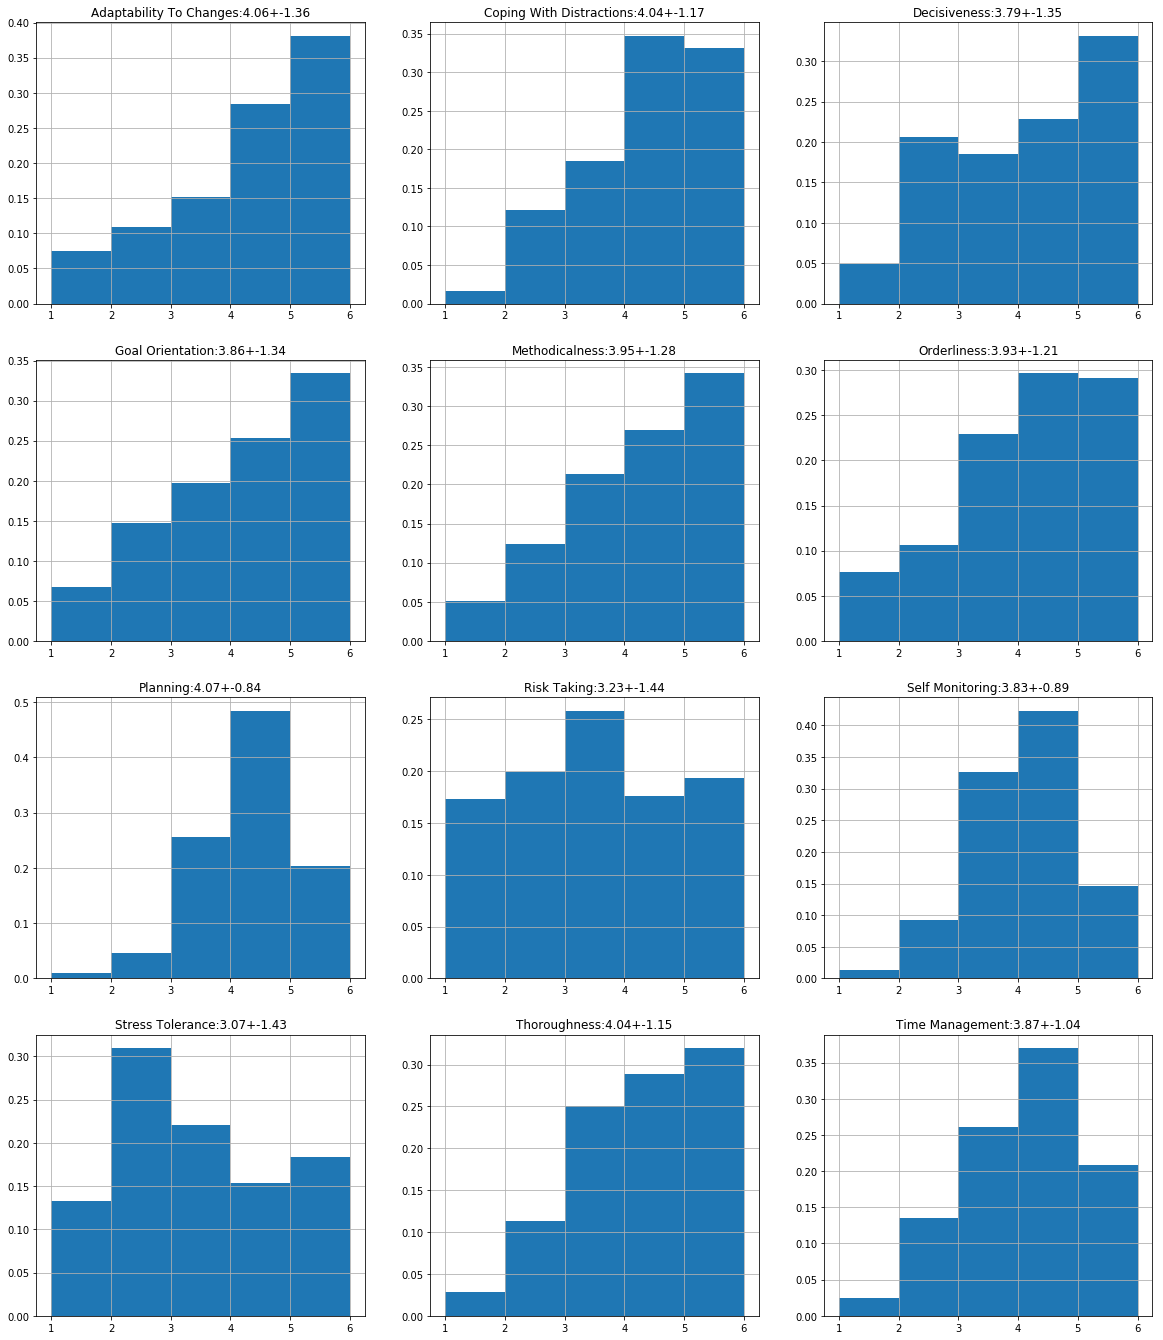

In [51]:
# create mean/median score df

label='Isa'
df_full = pd.DataFrame()

plt.figure(figsize=(20,30))

for i,target in enumerate(sorted(set(scores.index.get_level_values('Question')))):
    plt.subplot(5,3,i+1)
    target_scores = scores.loc[target]#,label]
    
    #n = number of subjects
    n = target_scores.shape[0]

    # remove 3-4 values, not indicative (equivalent to NaN)
    #target_scores[target_scores==3 or target_scores==4]=np.nan 

    target_scores = target_scores[target_scores.count(axis=1)>0] # remove subjects with no scores
    #print('\n',n-target_scores.shape[0],'subjects out of', n, 'with no score (', round((n-target_scores.shape[0])/n*100), '%)')
    n1=target_scores.shape[0] # n1 = number of subjects with scores
    #target_scores = target_scores[((target_scores>0).sum(axis=1)>1)] # remove subjects with only one score
    diff_scores = target_scores[target_scores.max(axis=1) - target_scores.min(axis=1)>1]
    #print(diff_scores.shape[0], 'subjects out of', n1, 'with difference in scores>1 (',round(diff_scores.shape[0]/n1*100), '%)')
    
    target_scores['mean']=np.nanmean(target_scores, axis=1)
    target_scores['median']=np.nanmedian(target_scores.drop(columns='mean'), axis=1)
    target_scores['std']=np.nanstd(target_scores.drop(columns=['mean','median']), axis=1)
    # set score to either mean or median depending on std
    target_scores.loc[target_scores['std']<1,'score'] = target_scores.loc[target_scores['std']<1,'mean']
    target_scores.loc[target_scores['std']>=1,'score'] = target_scores.loc[target_scores['std']>=1,'median']
    target_scores['score'].hist(density=True,bins=np.linspace(1,6,6))
    
    #print('MEAN=',round(target_scores['score'].mean(),2),'+-',round(target_scores['score'].std(),2))
    print(target,'n=',n1,':', round(target_scores['score'].mean(),2),
          '+-',round(target_scores['score'].std(),2))
    plt.title(target+':'+str(round(target_scores['score'].mean(),2))+'+-'+str(round(target_scores['score'].std(),2)))
    #plt.show()
    
    
    
#     if df_full.empty:
#         df_full[target] = target_scores['score']
#     else:
#         target_scores[target]=target_scores['score']
#         df_full=df_full.join(target_scores[target],how='outer')
   
#     #print('\n',target_scores[target_scores.drop(columns=['mean','median','std']).max(axis=1) - target_scores.drop(columns=['mean','median','std']).min(axis=1)>1])

In [73]:
df_order=df_full['Orderliness']
df_order=df_order.dropna()
print(df_order.shape)
df_order.to_csv(path_dataset+os.sep+'all_order_scores.csv')


(441,)


In [13]:
df_full.to_csv(path_dataset+os.sep+'Isa_observation_scores.csv')

In [68]:
df_full[target_variables].corr().to_csv('observation_scores_corr_mat.csv')
df_full[target_variables].corr()

NameError: name 'target_variables' is not defined

In [26]:
df_full['Coping With Distractions'].corr(df_full['Adaptability To Changes'])

0.7875525519294915

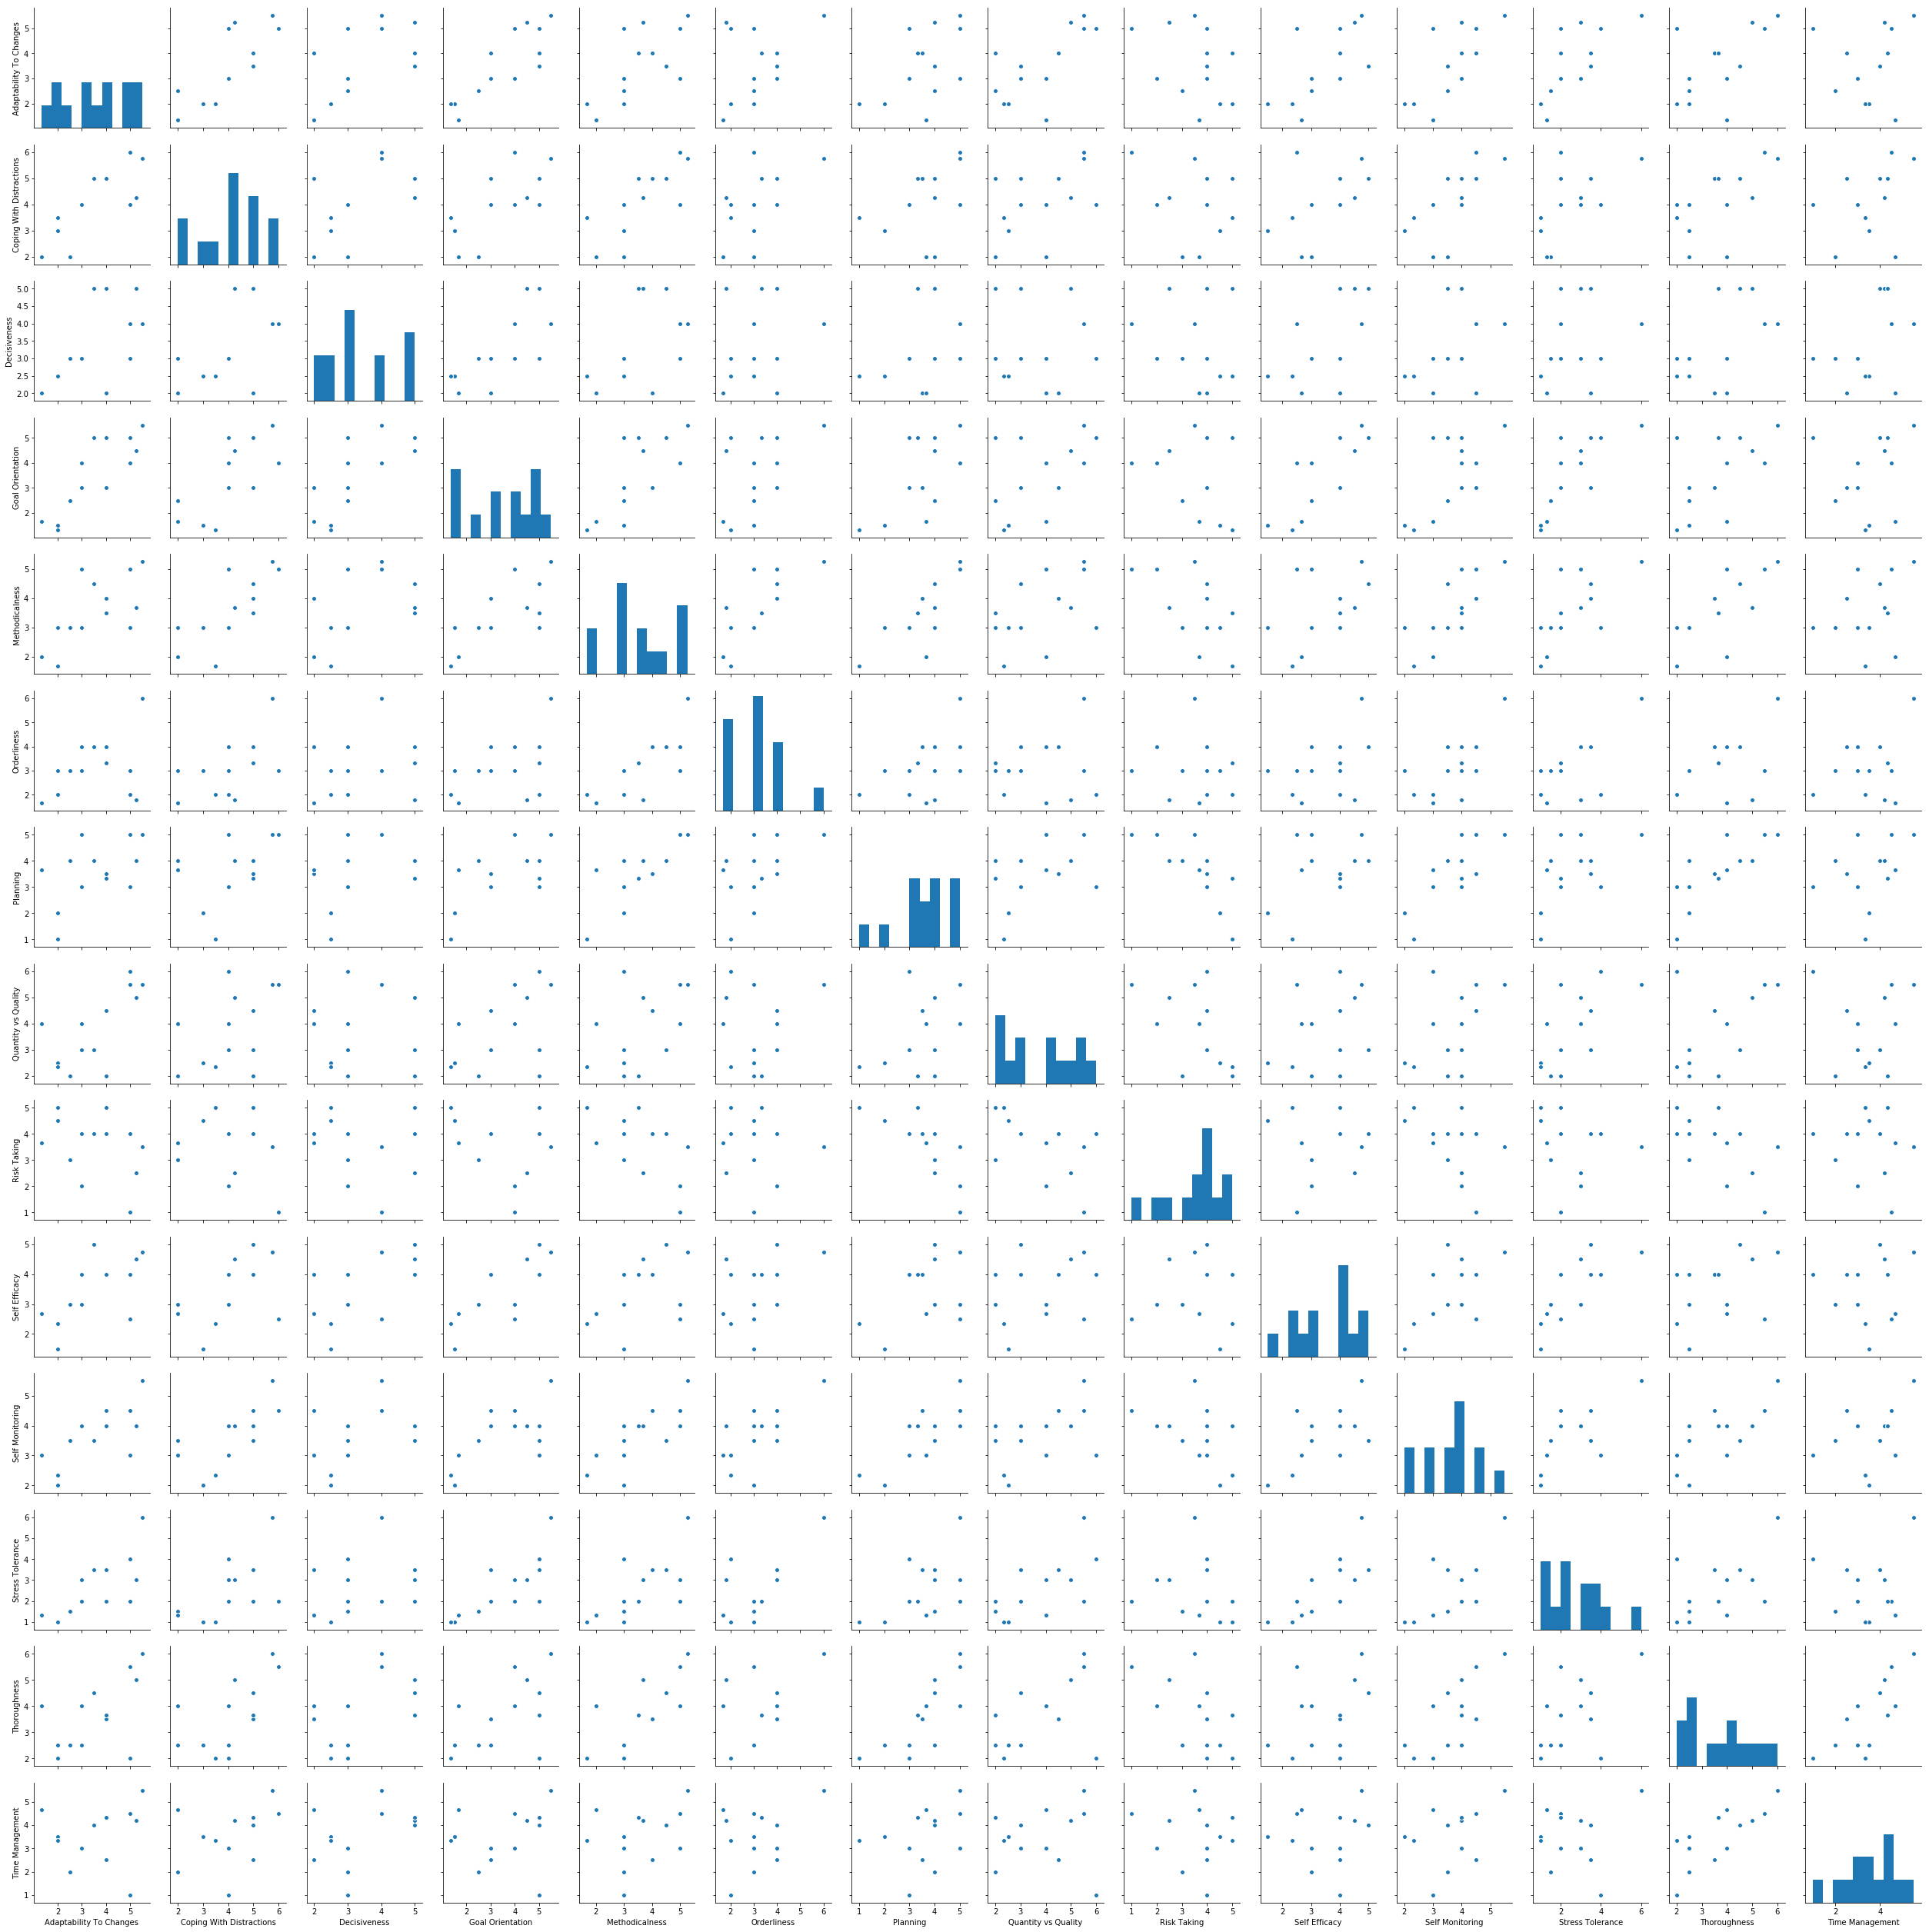

In [22]:
sns.pairplot(df_full[target_variables]) # distributions and correlation plots

In [56]:
df_full.shape

(259, 5)

In [59]:
df_full

,Decisiveness,Planning,Thoroughness,Time Management,Orderliness
MissionId,,,,,
5c358b19b5997b32b4ceaa99,6.000000,4.000000,4.500000,4.500000,2.500000
5c35a18eb5997b32b4ceaa9a,5.500000,5.000000,5.500000,6.000000,4.500000
5c35a1d0b5997b32b4ceaa9b,3.500000,5.500000,6.000000,5.500000,6.000000
5c3810aab5997b32b4ceaaa0,4.000000,5.000000,6.000000,5.500000,6.000000
5c3d2f0fb5997b32b4ceaaa1,2.500000,4.000000,3.500000,2.500000,5.000000
5c3d300fb5997b32b4ceaaa2,4.000000,3.500000,3.500000,2.500000,1.500000
5c3d3944b5997b32b4ceaaa3,4.500000,5.000000,4.500000,3.000000,1.500000
5c3d52b2b5997b32b4ceaaa4,4.500000,3.500000,3.500000,2.500000,3.500000
5c3d56e0b5997b32b4ceaaa5,4.000000,4.500000,5.500000,3.500000,6.000000


In [62]:
df_full=df_full.rename(columns={'MissionId':'id'})

In [72]:
df_full.index.names = ['id']


In [73]:
df_full.to_csv(path_dataset+os.sep+'observation_scores_df_17_01_19.csv')

In [98]:
import scipy.stats as sc

sc.percentileofscore(target_scores['score'],5.5,kind='mean')

96.06557377049181

In [26]:
df_full.empty
#target_scores[target_scores.drop(columns=['mean','median','std']).max(axis=1) - target_scores.drop(columns=['mean','median','std']).min(axis=1)>1]

False

                 planning  precision  time_management  thoroughness
planning         1.000000   0.995184         0.994670      0.977386
precision        0.995184   1.000000         0.995441           NaN
time_management  0.994670   0.995441         1.000000      0.976855
thoroughness     0.977386        NaN         0.976855      1.000000 



ValueError: max must be larger than min in range parameter.

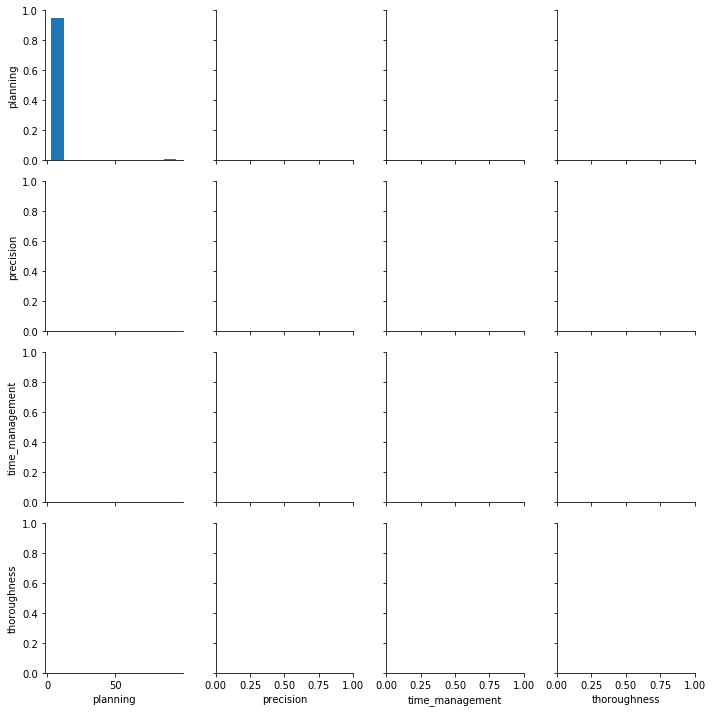

In [17]:
# plot ordinal targets' distributions and internal correlations
fig = plt.figure(figsize=(20,20))
target_variables = df_full.columns
# correlations between targets
df_full.replace('Null',np.nan,inplace=True)
print(df_full[target_variables].corr(method='pearson'),'\n') # correlation matrix
#plt.hist(df_full[target], bins=10) # histograms
#plt.scatter(df_full[target], df_full[targetj], edgecolor='k') # scatter
sns.pairplot(df_full[target_variables])#.drop(columns=['decisiveness','quality_vs_product'])) # distributions and correlation plots

plt.show()

In [21]:
df_full


,planning
Row Labels,
5bd70fb3d6834c2bd2944850,4.500000
5bd71087d6834c2bd2944851,4.833333
5bd71320d6834c2bd2944852,4.000000
5bd7133bd6834c2bd2944853,3.166667
5bebe20be8c7351bf1b4976e,5.333333
5bece7942777cd72ca32a958,3.666667
5bee5d433fce8c1cbe92c068,5.000000
5bee5ddc3fce8c1cbe92c069,4.000000
5bf264113fce8c1cbe92c06b,4.666667


PLANNING 

GalD  vs.  MaiaAsher n= 33 :  0.43625844240705375
GalD  vs.  MAYB n= 50 :  0.12645159645530857
GalD  vs.  NOAR n= 32 :  0.17169595957213074
GalD  vs.  Orga n= 39 :  0.248873920622432
GalD  vs.  RotemGal n= 39 :  0.46443990991313006
GalD  vs.  YARD n= 63 :  0.47201667948160064
MaiaAsher  vs.  YARD n= 39 :  0.47747612451027543
MAYB  vs.  RotemGal n= 37 :  0.2133362837141586
MAYB  vs.  YARD n= 36 :  0.07919849388524854
Orga  vs.  YARD n= 45 :  0.24266657635478572

mean correlation (n= 10 pairs)= 0.2932413986916124


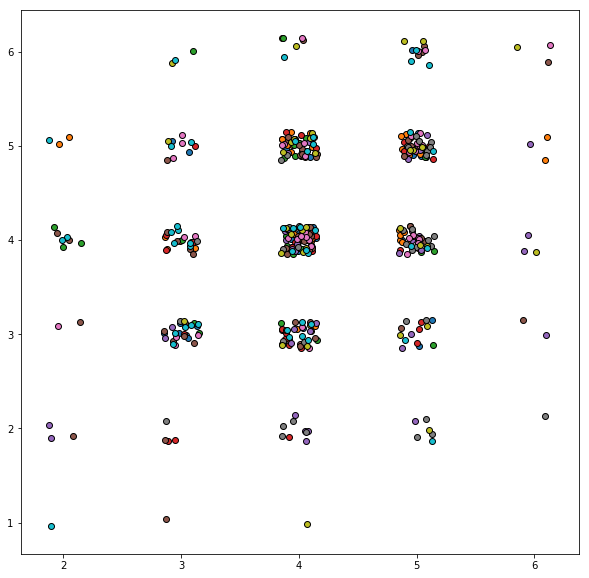

PRECISION 

GalD  vs.  MaiaAsher n= 30 :  0.7516938091671419
GalD  vs.  MAYB n= 46 :  0.6882396900199618
GalD  vs.  Orga n= 34 :  0.7401347884477535
GalD  vs.  RotemGal n= 36 :  0.6868889745146938
GalD  vs.  YARD n= 59 :  0.6534859788706614
MaiaAsher  vs.  YARD n= 39 :  0.6738134434816835
MAYB  vs.  RotemGal n= 38 :  0.5796647362338044
MAYB  vs.  YARD n= 35 :  0.39173607231246504
Orga  vs.  YARD n= 42 :  0.7383953483883108

mean correlation (n= 9 pairs)= 0.6560058712707195


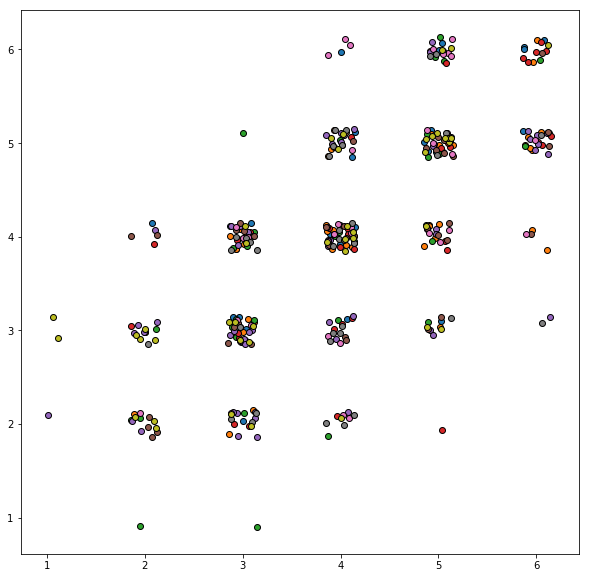

ORGANIZATION 

GalD  vs.  MaiaAsher n= 31 :  0.6740114351974481
GalD  vs.  MAYB n= 48 :  0.7807168799388831
GalD  vs.  Orga n= 36 :  0.8567491928248834
GalD  vs.  RotemGal n= 38 :  0.7272905716559728
GalD  vs.  YARD n= 62 :  0.8368563866909133
MaiaAsher  vs.  YARD n= 39 :  0.7481219148929948
MAYB  vs.  RotemGal n= 38 :  0.6471454865925349
MAYB  vs.  YARD n= 36 :  0.7267199529429902
Orga  vs.  YARD n= 44 :  0.8133442703873506

mean correlation (n= 9 pairs)= 0.7567728990137746


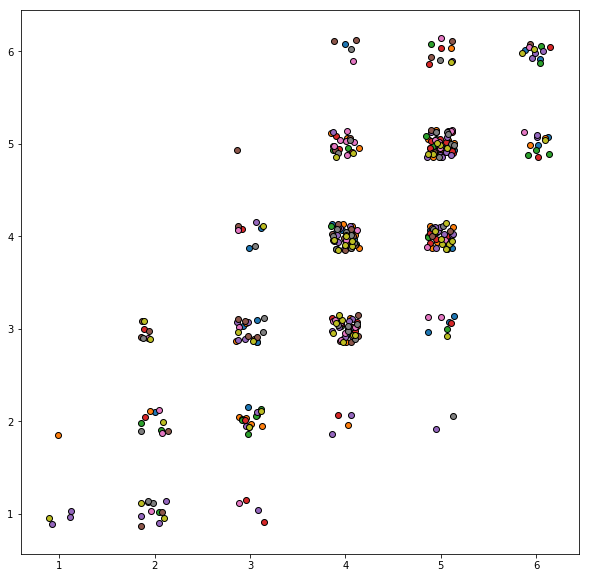

TIME_MANAGEMENT 

GalD  vs.  MaiaAsher n= 32 :  0.6888306603528931
GalD  vs.  MAYB n= 49 :  0.6053547915004002
GalD  vs.  NOAR n= 32 :  0.7558349939498309
GalD  vs.  Orga n= 39 :  0.6117471873466233
GalD  vs.  RotemGal n= 40 :  0.4514467722035126
GalD  vs.  YARD n= 61 :  0.19405059925600546
MaiaAsher  vs.  YARD n= 39 :  0.5445858070359944
MAYB  vs.  RotemGal n= 37 :  0.4628193523465382
MAYB  vs.  YARD n= 36 :  0.38944332377466
Orga  vs.  YARD n= 45 :  0.24391097439346843

mean correlation (n= 10 pairs)= 0.4948024462159927


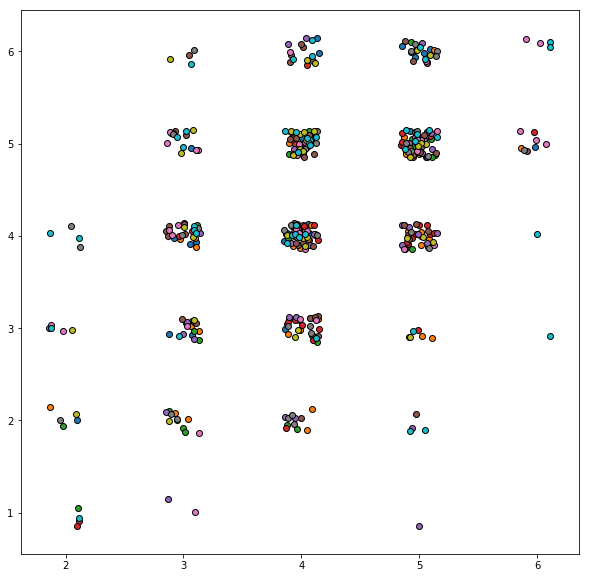

MONITORING 

GalD  vs.  MaiaAsher n= 33 :  0.40540429580232934
GalD  vs.  MAYB n= 49 :  0.30908151458176086
GalD  vs.  NOAR n= 32 :  0.39673455871724345
GalD  vs.  Orga n= 39 :  0.32963913988309207
GalD  vs.  RotemGal n= 40 :  0.5044737218174575
GalD  vs.  YARD n= 63 :  0.603396108525292
MaiaAsher  vs.  YARD n= 39 :  0.23945978162729045
MAYB  vs.  RotemGal n= 38 :  0.4609617229503433
MAYB  vs.  YARD n= 36 :  0.41478161637008154
Orga  vs.  YARD n= 45 :  0.4695640176024412

mean correlation (n= 10 pairs)= 0.41334964778773325


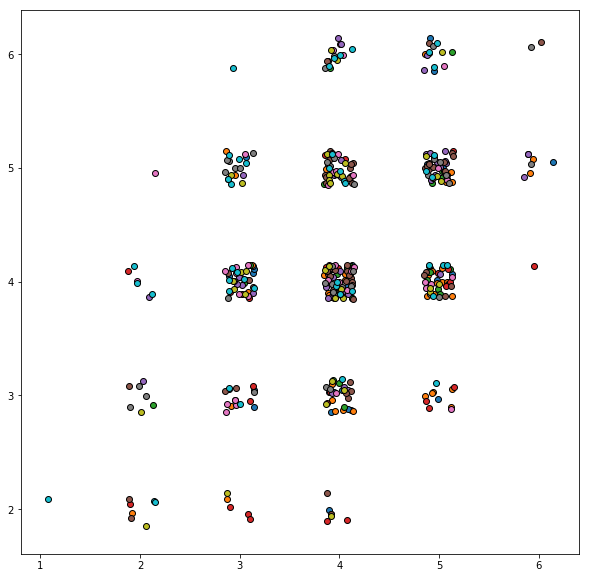

In [16]:
targets = ['planning',  'precision',  'organization',  'time_management',  'monitoring']

for target in targets:
    print(target.upper(),'\n')
    target_filename = os.path.join(path_dataset,target+'_psychologists_scores.csv')

    target_scores = pd.read_csv(target_filename, index_col=0)

    mean_corr = []
    k = 0
    fig = plt.figure(figsize=(10,10))
    for i, psyi in  enumerate(target_scores.columns):
        for j, psyj in enumerate(target_scores.columns[i+1:]):
            a = target_scores[(target_scores.loc[:,[psyi,psyj]]>0).all(axis=1)]
            if a.shape[0]>=30:
                a = a.loc[:,[psyi,psyj]]
                c = a.corr(method='pearson')
                mean_corr.append(c.loc[psyi,psyj])
                a = a + (np.random.rand(a.shape[0],a.shape[1])-0.5)*0.3
                plt.scatter(a[psyi], a[psyj], edgecolor='k')
                print(psyi,' vs. ', psyj, 'n=',a.shape[0],': ', c.loc[psyi,psyj])
                k+=1
    print('\nmean correlation (n=',k,'pairs)=',np.mean(mean_corr))
    plt.show()


PLANNING 

GalD  vs.  MaiaAsher n= 33 :  0.43625844240705375


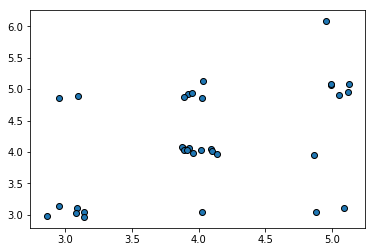

GalD  vs.  MAYB n= 50 :  0.12645159645530857


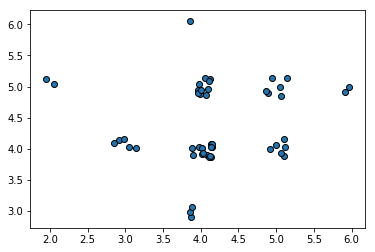

GalD  vs.  NOAR n= 32 :  0.17169595957213074


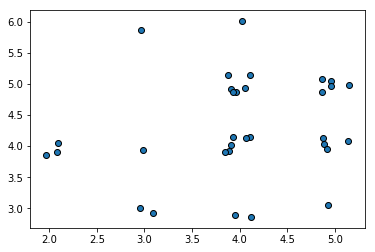

GalD  vs.  Orga n= 39 :  0.248873920622432


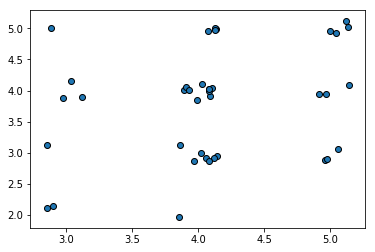

GalD  vs.  RotemGal n= 39 :  0.46443990991313006


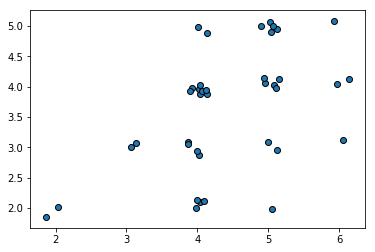

GalD  vs.  YARD n= 63 :  0.47201667948160064


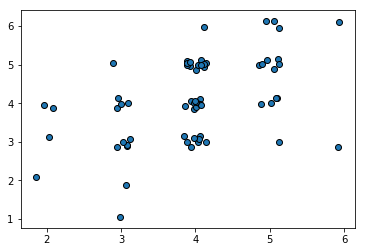

MaiaAsher  vs.  YARD n= 39 :  0.47747612451027543


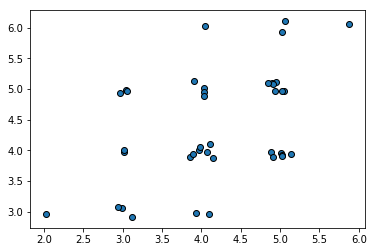

MAYB  vs.  RotemGal n= 37 :  0.2133362837141586


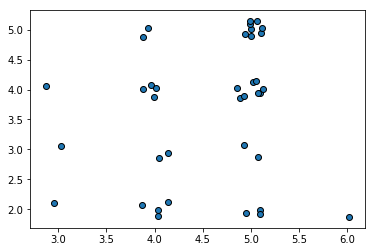

MAYB  vs.  YARD n= 36 :  0.07919849388524854


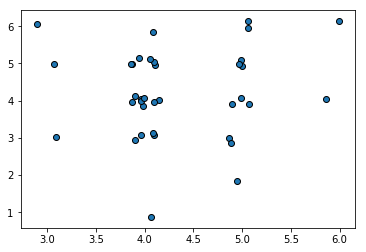

Orga  vs.  YARD n= 45 :  0.24266657635478572


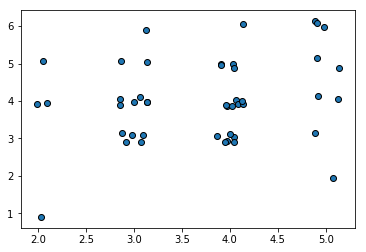

In [17]:
target = 'planning'
print(target.upper(),'\n')
target_filename = os.path.join(path_dataset,target+'_psychologists_scores.csv')

target_scores = pd.read_csv(target_filename, index_col=0)

#fig = plt.figure(figsize=(10,10))
for i, psyi in  enumerate(target_scores.columns):
    for j, psyj in enumerate(target_scores.columns[i+1:]):
        a = target_scores[(target_scores.loc[:,[psyi,psyj]]>0).all(axis=1)]
        if a.shape[0]>=30:
            a = a.loc[:,[psyi,psyj]]
            c = a.corr(method='pearson')
            a = a + (np.random.rand(a.shape[0],a.shape[1])-0.5)*0.3
            _=plt.scatter(a[psyi], a[psyj], edgecolor='k')
            _= plt.figure(figsize=(5,4))
            print(psyi,' vs. ', psyj, 'n=',a.shape[0],': ', c.loc[psyi,psyj])
            _= plt.show()

# define data set with all features and targets

In [44]:
target_variables_all

Index(['planning', 'precision', 'decisiveness', 'organization', 'time_manegement', 'Monitoring', 'quality_vs_product'], dtype='object')

Index(['planning', 'precision', 'decisiveness', 'organization', 'time_manegement', 'Monitoring', 'quality_vs_product'], dtype='object')
target: decisiveness


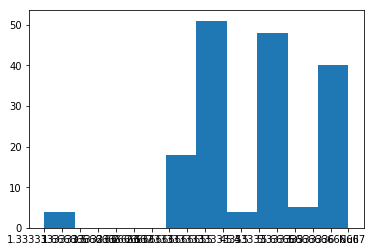

In [45]:
# choose one target
print(target_variables)
target_variables = target_variables_all[2:3]
target = target_variables[0]
print('target:', target)
plt.hist(df_full[target], bins=10) # histograms

# remove subjects with a specific target value
value_to_remove = np.nan #4
if ~np.isnan(value_to_remove):
    print('removing', value_to_remove, 'values from', target)
    df_full.drop(df_full[df_full[target]==value_to_remove].index,inplace=True)
    plt.hist(df_full[target], bins='auto')

In [33]:
all_columns=[]
all_columns.extend(target_variables.tolist())
all_columns.extend(features_variables)
df_full_chosen=df_full[all_columns].copy()
df_full_chosen.head(2)

,organization,atf.weightedScore,ptf.weightedScore,stf.weightedScore,ptf.meanNormRT,atf.meanNormRT,stf.meanNormCorrectRT,ptf.meanNormSteps
id,,,,,,,,
5BB3E29AAB7BC82E25CDCA50,5.0,2.678431,-2.544308,2.767923,0.030735,2.039985,0.115714,-0.206942
5BB3E81AAB7BC82E25CDCA54,1.0,3.313725,0.313927,-1.680926,-0.093020,0.245533,0.964648,0.173472


In [34]:
for feature in features_variables:
    print(feature)

atf.weightedScore
ptf.weightedScore
stf.weightedScore
ptf.meanNormRT
atf.meanNormRT
stf.meanNormCorrectRT
ptf.meanNormSteps


Monitoring vs. Monitoring 1.0


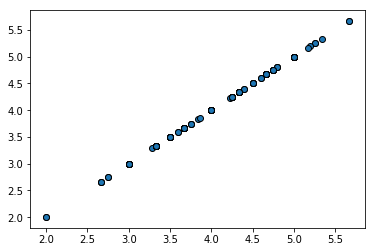

stf.r_atShpGrab_Sum_Sum vs. Monitoring 0.37


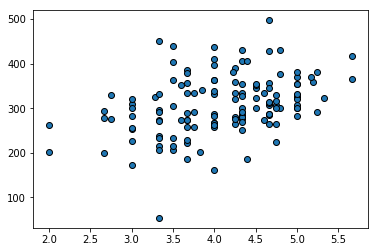

stf.r_sAccuracy_SumNot vs. Monitoring -0.36


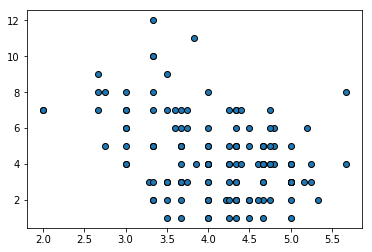

stf.r_sAccuracy_SumNotDivLen vs. Monitoring -0.36


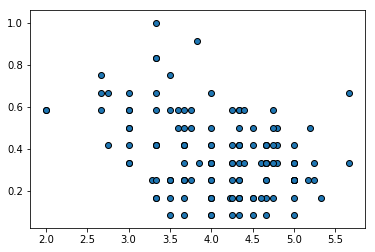

stf.r_tCompletion_Sum vs. Monitoring 0.38


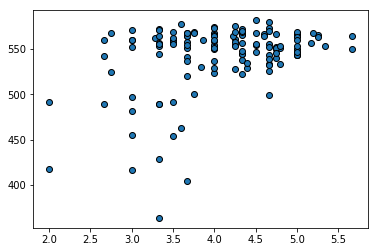

stf.r_tDone_Sum vs. Monitoring 0.44


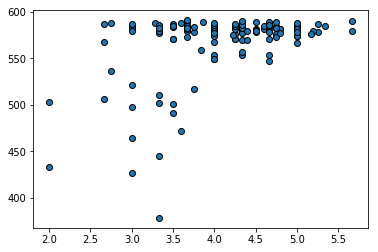

stf.r_tTargetGrab_Sum vs. Monitoring 0.3


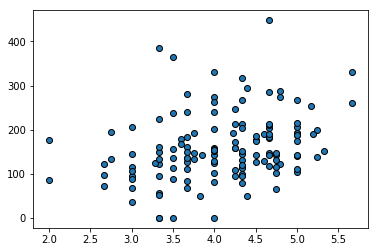

ptf.PieceHeldDuration_Sum vs. Monitoring -0.38


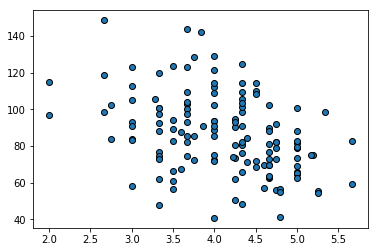

atf.tCompletionToDone_Q4 vs. Monitoring 0.3


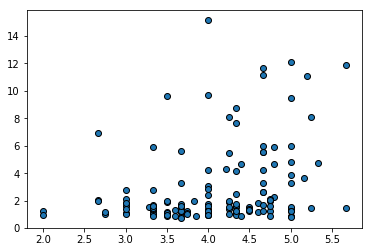

atf.tCompletionToDone_Q_multi vs. Monitoring 0.33


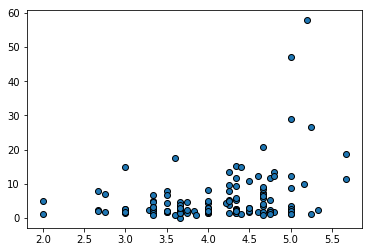

[['Monitoring', 1.0],
 ['stf.r_atShpGrab_Sum_Sum', 0.37],
 ['stf.r_sAccuracy_SumNot', -0.36],
 ['stf.r_sAccuracy_SumNotDivLen', -0.36],
 ['stf.r_tCompletion_Sum', 0.38],
 ['stf.r_tDone_Sum', 0.44],
 ['stf.r_tTargetGrab_Sum', 0.3],
 ['ptf.PieceHeldDuration_Sum', -0.38],
 ['atf.tCompletionToDone_Q4', 0.3],
 ['atf.tCompletionToDone_Q_multi', 0.33]]

In [48]:
corr_thresh = 0.3
list_high_corr=[]
for i in df_full_chosen.columns:
    df_full_t=df_full_chosen.dropna(subset=[target,i], axis=0, inplace=False).copy()
    
    if abs(np.corrcoef(df_full_t[target], df_full_t[i])[0,1])>corr_thresh:
        list_high_corr.append([i,round(np.corrcoef(df_full_t[target], df_full_t[i])[0,1],2)])        
        plt.scatter(df_full_t[target], df_full_t[i], edgecolor='k')
        fig = plt.figure(figsize=(10,8))
        print(i ,'vs.', target, round(np.corrcoef(df_full_t[target], df_full_t[i])[0,1],2))
        plt.show()
        
list_high_corr

,atf.weightedScore,ptf.weightedScore,stf.weightedScore,ptf.meanNormRT,atf.meanNormRT,stf.meanNormCorrectRT,ptf.meanNormSteps
organization,0.158982,0.285892,0.338998,0.272162,0.009324,0.075367,0.305579


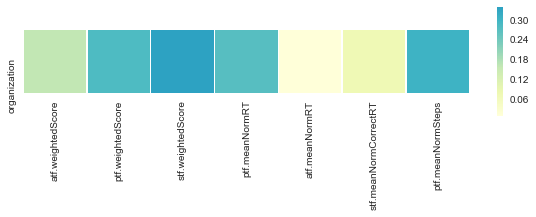

In [35]:
#target='Weschler.15_verbal_IQ_percentile'
#target='Weschler.25_prossecing_speed_percentile'
features_variables=['atf.weightedScore','ptf.weightedScore','stf.weightedScore','ptf.meanNormRT','atf.meanNormRT','stf.meanNormCorrectRT','ptf.meanNormSteps'] #

#target='21_perceptual_organizartion_percentile'
features_variables=['ptf.meanNormRT', 'ptf.weightedScore', 'ptf.i_at1stSwap_Avg', 'ptf.t_tCompletionToDone', 'atf.meanNormRT', 'atf.sumDivLen_no5', 'stf.r_sAccuracy_Avg']

#target='21_perceptual_organizartion_percentile'
features_variables=['ptf.meanNormRT', 'ptf.r_sAccuracy_SumNot', 'ptf.i_tSelectionToSwap_Sum', 'atf.meanNormRT', 'atf.sumDivLen_no5', 'stf.r_sAccuracy_SumNot']

#target='15_verbal_IQ_percentile'
features_variables=['atf.r_t1stGrab_Sum', 'atf.weightedScore_no45']

#target = 'planning'
features_variables=['atf.weightedScore','ptf.weightedScore','stf.weightedScore','ptf.meanNormRT','atf.meanNormRT','stf.meanNormCorrectRT',
                    'stf.r_atShpGrab_Sum_Avg','stf.r_tTargetGrab_Sum','stf.r_t1stGrab_Avg',
                    'ptf.FirstSwapCorrect_Avg','ptf.i_nSwap_Avg','ptf.PieceHeldDuration_Sum',
                    'ptf.i_tSolutionToNextSolve_Avg','ptf.i_at1stSwap_Avg', 'ptf.RoundFractionSwapsVsMinSwaps_Avg']

# target = 'monitoring'
features_variables=['atf.weightedScore','ptf.weightedScore','stf.weightedScore','atf.tCompletionToDone_Q4','atf.tCompletionToDone_Q_multi','stf.r_sAccuracy_SumNotDivLen']
          
    
# target = 'time_management'
features_variables=['atf.weightedScore','ptf.weightedScore','stf.weightedScore','ptf.meanNormRT','atf.meanNormRT','stf.meanNormCorrectRT','ptf.meanNormSteps'] #

columns_run=[target]
columns_run.extend(features_variables)
#df_full_chosen[columns_run].head(5)

path_target=path_save+os.sep+target
if not os.path.exists(path_target):
    os.makedirs(path_target)
    
#len_vr=len(df_full_chosen.columns[(df.columns.str.contains("ptf.|stf."))])
#len_targets = len(target_variables)
tmp = df_full_chosen[columns_run].corr(method='pearson').abs()
cdf=tmp
cdf=tmp.iloc[:len(target_variables),len(target_variables):]

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(cdf, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
#cmap = sns.light_palette("purple")
cmap="YlGnBu"
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cdf, mask=mask, cmap=cmap, vmax=cdf.max().max(), center=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .2});
cdf

In [36]:
randstate = np.random.randint(1000,size=len(target_variables))
used_features, results, all_results_Xs = find_best_model_for_target(df_full_chosen[columns_run], target_variables[0],randstate[0], n_jobs=1) 

modeling organization
featuers: ['atf.weightedScore', 'ptf.weightedScore', 'stf.weightedScore', 'ptf.meanNormRT', 'atf.meanNormRT', 'stf.meanNormCorrectRT', 'ptf.meanNormSteps']


target = organization, nSub = 170 of 170
find_model
 target 'organization': linear model run (17 seconds), best result 0.38, std 0.124
 target 'organization': SVR run (55 seconds), best corr result 0.376, std 0.117
 target 'organization': X1 ((170, 7)) - correlation = 0.380, std = 0.124; RMSE = -0.933, std = 0.085 (72 seconds)
finished target 'organization', nFeatures=8 with mean corr = 0.380, mean corr std = 0.124; and mean RMSE =-0.933, mean RMSE std = 0.085 (total time= 72 seconds)


In [187]:
txt='hagar'
txt[::-1]
used_features
features_variables

['atf.weightedScore',
 'ptf.weightedScore',
 'stf.weightedScore',
 'atf.tCompletionToDone_Q4',
 'atf.tCompletionToDone_Q_multi',
 'stf.r_sAccuracy_SumNotDivLen']

In [188]:
features_variables

['atf.weightedScore',
 'ptf.weightedScore',
 'stf.weightedScore',
 'atf.tCompletionToDone_Q4',
 'atf.tCompletionToDone_Q_multi',
 'stf.r_sAccuracy_SumNotDivLen']

In [185]:
results#[mean_test_corr]
results_df = pd.DataFrame.from_dict(results)
results_df

,Monitoring
mean_fit_time,0.0043618
mean_score_time,0.00177064
mean_test_corr,0.604947
mean_test_rmse,-0.584316
param_model,"Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr..."
param_model__alpha,0.2
param_model__normalize,False
params,"{'model': Ridge(alpha=0.2, copy_X=True, fit_in..."
rank_test_corr,1
rank_test_rmse,1


In [106]:
warnings.filterwarnings("ignore")


from concurrent.futures import ProcessPoolExecutor
#"""
for i in range(0,1):
       
    path_target=path_save+os.sep+target_variables.values[0]+str(i)
    print('\npathsave = ',path_target)
    if not os.path.exists(path_target):
        os.makedirs(path_target)
   
    rand_list = np.random.randint(2**32-1,size=np.size(target_variables))

    used_features = dict()
    results = dict()
    all_results_Xs = dict()

    threshold = 0.2
    forest_top_frac = 0.1 #0.3
    t0 = time.time()

    # FIXME:  dataset
    
    with ProcessPoolExecutor(max_workers=n_jobs_targets) as pool:
        for job_result in pool.map(find_best_model_for_target, target_variables, rand_list):
            job_used_features, job_results, job_all_results_Xs = job_result
            used_features.update(job_used_features)
            results.update(job_results)
            all_results_Xs.update(job_all_results_Xs)

    t1 = time.time()
    gc.collect()
    print(f'\nprocess took {t1-t0:.0f} seconds. average per target is {(t1-t0)/len(target_variables):.0f} seconds')
  




pathsave =  /Users/Hagar/Google Drive/ActiViewData/Data/Modeling/19.11/Weschler.17_performance_IQ_percentile0


TypeError: find_best_model_for_target() missing 1 required positional argument: 'randstate'